# Distort character images

Program works by loading images from their respective folders in the central data store, applying specified distortions to reduce the quality and then saving the image back to the correct folder.

In [114]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import os
from wand.api import library
import wand.color
import wand.image
import numpy as np
from skimage import measure
from PIL import Image
from scipy import ndimage
import random

data_dir = './source'
img_filetype = '.png'

# The range of characters to distort
char_from = 1
char_to = 5

(480, 640)


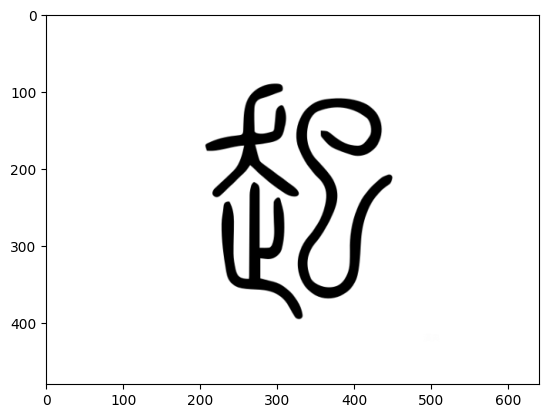

In [115]:
# Param: file - the filename of the image e.g. 1_1, 3_10, 150_2 etc.
# Returns image as numpy array
def load_image(file):
    img_folder = file[0:file.index('_')]
    img = Image.open(os.path.join(data_dir, img_folder, file)+img_filetype).convert('L')
    
    im = np.asarray(img)
        
    return im

im = load_image('1_1')
print(im.shape)
plt.imshow(im, cmap='gray')
plt.show()

In [131]:


def binarise_image(im, thresh):
    idx = (im < thresh)
    
    binary_im = np.zeros(im.shape, dtype='int')
    
    binary_im[idx] = 255
    binary_im[~idx] = 0
    
    return binary_im

def extract_character(im):
    binary_im = binarise_image(im, 200) # Input images should be black & white anyway, so 128 is arbitrary
#     plt.imshow(binary_im)
#     plt.show()
    # threshold at 200
    threshed = np.zeros(im.shape, 'int')
    threshed[im<200] = 1
    
    comps = measure.label(threshed, background=0)
    
    component_map, labels = comps, np.unique(comps)

    min_x = im.shape[0]
    min_y = im.shape[1]
    max_x = 0
    max_y = 0
    for label in labels[1:]:
        char_box = char_bounding_box(component_map, label)
        min_x = np.min(np.array([min_x, char_box[0]]))
        min_y = np.min(np.array([min_y, char_box[1]]))
        max_x = np.max(np.array([max_x, char_box[2]]))
        max_y = np.max(np.array([max_y, char_box[3]]))

#     print(min_x, max_x, min_y, max_y)
#     extracted_char = np.zeros((max_y-min_y+1, max_x-min_x+1), dtype='int')
    extracted_char = np.array(im[min_y:max_y, min_x:max_x])

#     print('unique labels in comps are ', np.unique(comps))
#     print(np.count_nonzero(comps))
    
#     # make a colour map of random colors
#     rand_colors = np.random.rand(256,3)
#     rand_colors[0,:] = 0.0 # black at zero index
#     rand_cmap = mpl.colors.ListedColormap(rand_colors)

    #print(rand_colors)
#     fig = plt.figure(figsize=(10,10))
#     plt.imshow(comps, cmap=rand_cmap)
#     plt.axis('off')
#     plt.show()
    return extracted_char
    
# find the coordinate bounding box of a given label in a components image
def char_bounding_box(comps, label=1):
    
    # array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0,comps.shape[1]), np.arange(0,comps.shape[0]))

    # mask/select by where value is given label (component)
    where_x = xx[comps==label]
    where_y = yy[comps==label]
    
    # find min and max extents of coordinates
    return np.min(where_x), np.min(where_y), np.max(where_x), np.max(where_y)   

# Return image im with size shape_from after padding with 255 (white) to size shape_to
def pad_image(shape_to, shape_from, im):
    # Amount of pixels to pad before and after rotated image in x and y directions, to return to original size
    pad_x = int(np.ceil((shape_to[1]-shape_from[1])/2))
    pad_y = int(np.ceil((shape_to[0]-shape_from[0])/2))

    padded_image = np.pad(im, ((pad_y,pad_y-1),(pad_x,pad_x-1)), 'constant', constant_values=(255))
    
    return padded_image

In [140]:
def rotate_char(im, std, rot):
    
    extracted_char = extract_character(im)
    rotated_char = ndimage.rotate(extracted_char, rot, reshape=True, mode='constant', cval=255)
    
    rotated_image = pad_image(im.shape, rotated_char.shape, rotated_char)
    
    return rotated_image

def add_gaussian_noise(img, std, rot):
    noise = np.random.normal(0, std, img.shape) 

    # Add the noise to the image
    img_noised = img + noise

    # Clip the pixel values to be between 0 and 255.
    img_noised = np.clip(img_noised, 0, 255).astype(np.uint8)
    
    return img_noised

def add_gaussian_blur(img, std, rot):
    std = int(std//10)
    gauss_blurred = ndimage.gaussian_filter(img, std)
    
    return gauss_blurred

def remove_block(img, std, rot):
    block_size = 40
    extracted_char = extract_character(img)
    print(extracted_char.shape)
    rand_x = random.randint(0, extracted_char.shape[0]-block_size)
    rand_y = random.randint(0, extracted_char.shape[1]-block_size)
    print(rand_x, rand_y)
    extracted_char[rand_x:rand_x+block_size, rand_y:rand_y+block_size] = 255
    
    
    padded_image = pad_image(img.shape, extracted_char.shape, extracted_char)
    return padded_image

(305, 242)
73 1


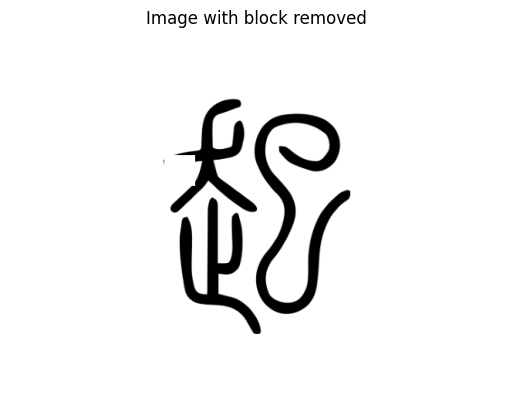

In [144]:
block = remove_block(im, 0, 0)

plt.imshow(block, cmap='gray')
plt.axis('off')
plt.title('Image with block removed')
plt.show()

In [145]:
def add_effects(im):
    num_effects = random.randint(1, 4)
    effect_image = np.copy(im)
    for f in range(num_effects):
        
        
        ### Function parameters:
        #   im - the input image
        #   std - the standard deviation of gaussian filters, 1 <= std <= 100
        #   rot - the degree of rotation, -90 <= rot <= 90

        effects = {
            1: rotate_char,
            2: add_gaussian_noise,
            3: add_gaussian_blur,
            4: remove_block
        }

        effect_image = effects[random.randint(1,len(effects))](effect_image, random.randrange(10, 100, 10), random.randint(-30, 30))


#         plt.imshow(effect_image, cmap='gray')
#         plt.title('random effect')
#         plt.show()
        
    return effect_image
        
        
# add_effects(im)

# rotated_image = rotate_char(im, 50, -45)


# plt.imshow(rotated_image, cmap='gray')
# plt.title('padded rotated char')
# plt.show()

# noised_image = add_gaussian_noise(rotated_image, 100, -50)

# plt.imshow(noised_image, cmap='gray')
# plt.title('noised image')
# plt.show()

# blurred_image = add_gaussian_blur(rotated_image, 3, -50)

# plt.imshow(blurred_image, cmap='gray')
# plt.title('blurred image')
# plt.show()

In [111]:
for root, dirs, files in os.walk(data_dir):
    for name in files:
        if '.png' in name and char_to >= int(name[:name.index('_')]) >= char_from:
            print(f'Adding effects to file {name}')
            filename = name[:name.index('.')]
            path = os.path.join(root, name)
            print(filename)
            
            print('Loading file...')
            im = load_image(filename)
            print('Adding effects...')
            edited_image = add_effects(im)
            
            # Get list of filenames of versions of current image, e.g. 1_1, 1_2, ... , 1_10
            versions_list = [x for x in files if filename[:filename.index('_')+1] in x]
            
            # Increment index of last version - MIGHT BREAK IF #VERSIONS > 10
            last_version = versions_list[-1]
            new_filename = last_version[0:last_version.index('_')+1] + str(int(last_version[last_version.index('_')+1:last_version.index('.')])+1) + last_version[last_version.index('.'):]
            new_image_path = path.replace(name, new_filename)
            
            plt.imsave(new_image_path, edited_image, cmap='gray')
            
#             plt.imshow(edited_image, cmap='gray')
#             plt.axis('off')
#             plt.show()
            
            print(f'Edited image saved to {new_image_path}')

Adding effects to file 1_1.png
1_1
Loading file...
Adding effects...
Edited image saved to ./source\1\1_2.png
Adding effects to file 2_1.png
2_1
Loading file...
Adding effects...
Edited image saved to ./source\2\2_2.png
Adding effects to file 3_1.png
3_1
Loading file...
Adding effects...
Edited image saved to ./source\3\3_2.png
Adding effects to file 4_1.png
4_1
Loading file...
Adding effects...
Edited image saved to ./source\4\4_2.png
Adding effects to file 5_1.png
5_1
Loading file...
Adding effects...
Edited image saved to ./source\5\5_2.png
